<p id = 'toc'></p>

<h1 style = "font-family:Verdana; font-size:24px; font-weight: bold; letter-spacing: 3px; color: teal;"> TABLE OF CONTENTS </h1>

---

[<h3 style = "font-family: Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal">0&nbsp;&nbsp;&nbsp;&nbsp; IMPORTS </h3>](#0)

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#1'>1.&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#2'>2.&nbsp;&nbsp;&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#3'>3.&nbsp;&nbsp;&nbsp;&nbsp;VISUALIZATIONS</a></h3>

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#4'>4.&nbsp;&nbsp;&nbsp;&nbsp;DATA LOADER</a></h3>


<a id = '0'></a>
# <span><center style = "font-family: Verdana; font-size:36px; color : teal; letter-spacing: 3px; font-weight: bold">0. &nbsp;IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a></center></span>

In [1]:
# pip install pydicom

In [2]:
import pandas as pd 
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import cv2
import shutil
import random

from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.io import read_image
from pydicom import dcmread
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [3]:
class config:
    TRAIN_PATH = '../input/unifesp-x-ray-body-part-classifier/train'
    TRAIN_CSV = '../input/unifesp-x-ray-body-part-classifier/train.csv'
    TEST_CSV = '../input/unifesp-x-ray-body-part-classifier/sample_submission.csv'
    WORKING_PATH = './'
    TRAIN_JPG_PATH = '../input/unifesp-xray-body-part-classifier-dataset-jpg/dataset/train'
    TEST_JPG_PATH = '../input/unifesp-xray-body-part-classifier-dataset-jpg/dataset/test'
    RANDOM_SEED = 15
    resize_size = [270,270]
    img_size = [256,256]
    train_bs = 32
    val_bs = 64
    device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
    

In [4]:
def set_seed(seed = config.RANDOM_SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print("--> SEEDING DONE")
    
    
set_seed()

--> SEEDING DONE


<a id="1"></a>

# <span><center style= "font-family:Verdana; font-size:36px; font-weight: bold; letter-spacing: 3px; color: teal">1.&nbsp;&nbsp;DATASET&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a> </center></span>

In [5]:
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)
print('Traning dataframe')
display(train_df.head())
print()
print('Submission dataframe')
display(test_df.head())

Traning dataframe


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3



Submission dataframe


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [6]:
def image_path_creation(path, replace_part):
    file_names = []
    full_paths = []
    for dirpath,  dirname, filenames in os.walk(path):
        if filenames:
            for filename in filenames:
                full_path = os.path.join(dirpath, filename)
                filename = filename.replace(replace_part, '')
                full_paths.append(full_path)
                file_names.append(filename)
    return file_names, full_paths

In [7]:
file_names, full_paths = image_path_creation(config.TRAIN_PATH, '-c.dcm')
image_path_dict = {'SOPInstanceUID': file_names, 'path':full_paths}
image_df = pd.DataFrame(image_path_dict)

In [8]:
train_df = pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [9]:
train_df.head(8)

,SOPInstanceUID,Target,path
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,../input/unifesp-x-ray-body-part-classifier/tr...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,../input/unifesp-x-ray-body-part-classifier/tr...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,../input/unifesp-x-ray-body-part-classifier/tr...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,../input/unifesp-x-ray-body-part-classifier/tr...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,../input/unifesp-x-ray-body-part-classifier/tr...
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,../input/unifesp-x-ray-body-part-classifier/tr...
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,../input/unifesp-x-ray-body-part-classifier/tr...
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,../input/unifesp-x-ray-body-part-classifier/tr...


In [10]:
train_df.shape

(1738, 3)

<a id="2"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">2.&nbsp;&nbsp;CONVERTING IMAGE DATA TO JPG&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [11]:
def read_dicom_image(path):
    dicom_file = dcmread(path)
    image = dicom_file.pixel_array
    image = image/image.max()
    return image

In [12]:
def save_image_jpg(path, save_path_name):
    image = read_dicom_image(path)*255
    plt.imsave(save_path_name, image)

In [13]:
os.listdir()

['.virtual_documents', '__notebook_source__.ipynb']

In [14]:
# shutil.rmtree('./train')

In [15]:
# Saving jpg images to working directory

# os.mkdir('./train')

# for i in tqdm(range(1000, train_df.shape[0])):
#     save_image_jpg(train_df.path[i], f'./train/{train_df.SOPInstanceUID[i]}.jpg')

In [16]:
file_names, file_paths = image_path_creation(config.TRAIN_JPG_PATH, '.jpg')
image_df = {'SOPInstanceUID': file_names, 'path_jpg':file_paths}
image_df = pd.DataFrame(image_df)

In [17]:
# os.listdir(config.TRAIN_JPG_PATH)

In [18]:
image_df#, train_df.SOPInstanceUID[0]

,SOPInstanceUID,path_jpg
0,1.2.826.0.1.3680043.8.498.51835086258445943007...,../input/unifesp-xray-body-part-classifier-dat...
1,1.2.826.0.1.3680043.8.498.12988003902739370568...,../input/unifesp-xray-body-part-classifier-dat...
2,1.2.826.0.1.3680043.8.498.19650035668800346959...,../input/unifesp-xray-body-part-classifier-dat...
3,1.2.826.0.1.3680043.8.498.74830143260178495808...,../input/unifesp-xray-body-part-classifier-dat...
4,1.2.826.0.1.3680043.8.498.11801731889437582722...,../input/unifesp-xray-body-part-classifier-dat...
...,...,...
1733,1.2.826.0.1.3680043.8.498.38003384196713521267...,../input/unifesp-xray-body-part-classifier-dat...
1734,1.2.826.0.1.3680043.8.498.67425855378177166596...,../input/unifesp-xray-body-part-classifier-dat...
1735,1.2.826.0.1.3680043.8.498.11289861194566314326...,../input/unifesp-xray-body-part-classifier-dat...
1736,1.2.826.0.1.3680043.8.498.91674382289874592333...,../input/unifesp-xray-body-part-classifier-dat...


In [19]:
train_df_jpg=pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [20]:
train_df_jpg.head()

,SOPInstanceUID,Target,path,path_jpg
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...


In [21]:
train_df_jpg.SOPInstanceUID[0], train_df_jpg.path_jpg[0].split('/')[-1]

('1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258',
 '1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258.jpg')

image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)<a id="3"></a>

# <span><center style = "font-family:Didot; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">3.&nbsp;&nbsp;DATA EXPLORATION AND VISUALIZATIONS&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [22]:
train_df_jpg.Target.value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

So there is Some problem in labels, lets check them out

In [23]:
train_df_jpg.dtypes

SOPInstanceUID    object
Target            object
path              object
path_jpg          object
dtype: object

In [24]:
train_df_jpg['label_count']=train_df_jpg.Target.map(lambda x: len(x.split()))

In [25]:
train_df_jpg['Target_list']=train_df_jpg.Target.map(lambda x: [int(i) for i in x.split()])

Y = train_df_jpg['Target_list']

multilabel_encoder = MultiLabelBinarizer()
Y_transformed=multilabel_encoder.fit_transform(Y)
label_columns = []

for i in range(Y_transformed.shape[1]):
    name = f'label_{i}'
    train_df_jpg[name] = Y_transformed[:,i]
    label_columns.append(name)
    
    

In [26]:
label_columns = [column for column in train_df_jpg.columns if 'label_' in column]

In [27]:
label_columns = label_columns[1:]

In [28]:
train_df_jpg.head(8)

,SOPInstanceUID,Target,path,path_jpg,label_count,Target_list,label_0,label_1,label_2,label_3,...,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19,label_20,label_21
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[0],1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[15],0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[12],0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[14],0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[3],0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[3],0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,1,[14],0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,../input/unifesp-x-ray-body-part-classifier/tr...,../input/unifesp-xray-body-part-classifier-dat...,2,"[13, 20]",0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


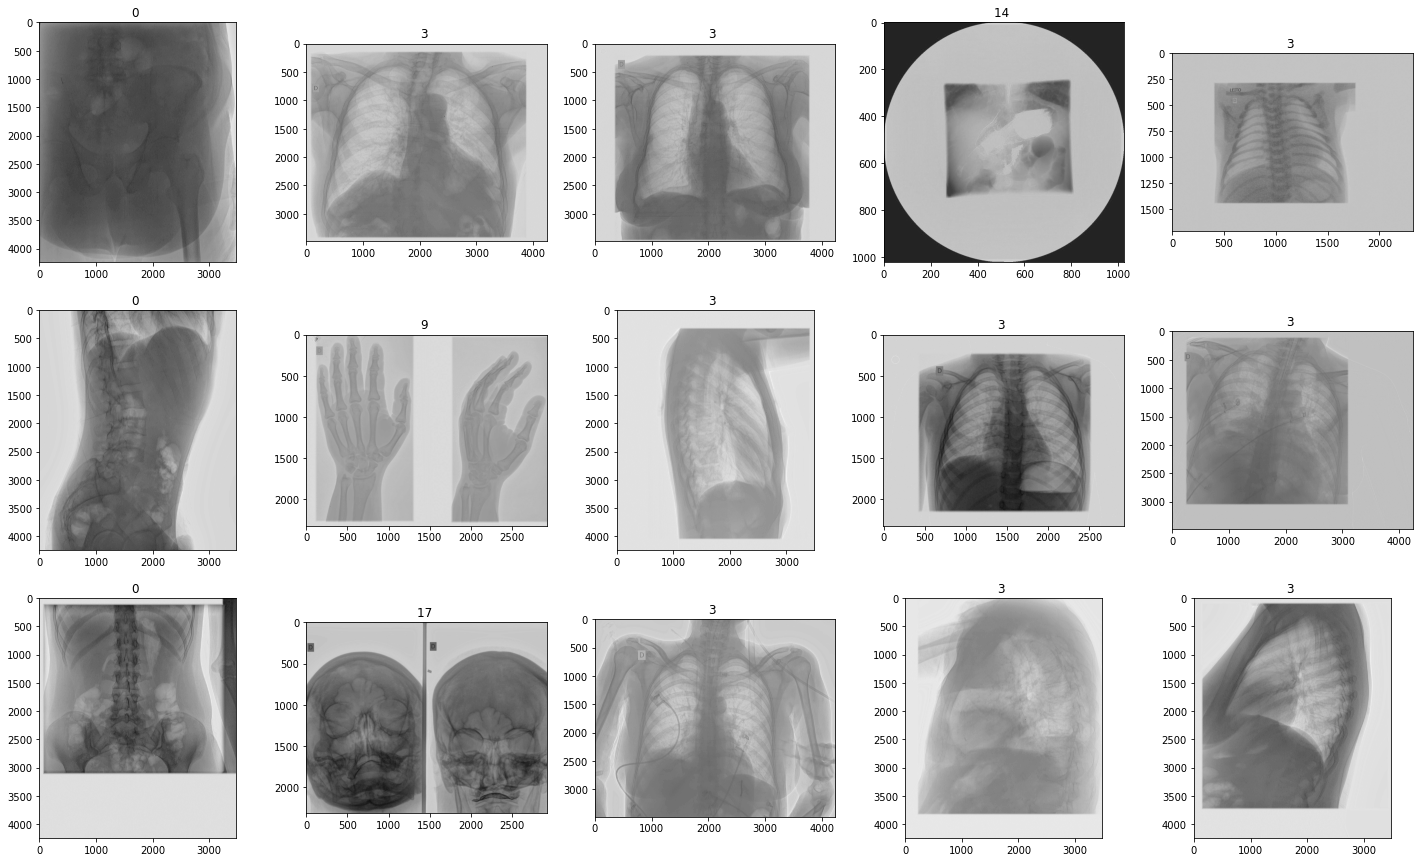

In [29]:
fig = plt.figure(figsize=(25,15))
for i in range(15):
    ax = fig.add_subplot(3,5, i+1)
#     image = read_dicom_image(train_df.path_jpg[i*5])
    img = np.array(Image.open(train_df_jpg.path_jpg[i*5]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img, cmap = 'gray')
    ax.set_title(train_df.Target[i*5])

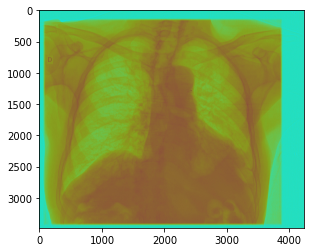

In [30]:
img = cv2.imread(train_df_jpg.path_jpg[5])
plt.imshow(img)

<a id="4"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">3.&nbsp;&nbsp;SAVING RESIZED IMAGES&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>


In [31]:
image = cv2.imread(train_df_jpg.path_jpg[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = cv2.resize(image, config.resize_size)

In [32]:
cv2.imwrite()

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - imwrite() missing required argument 'filename' (pos 1)
>  - imwrite() missing required argument 'filename' (pos 1)


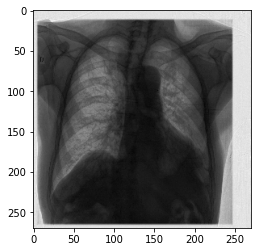

In [33]:
plt.imshow(image, cmap = 'gray')

In [34]:
# save resized images

def save_resized_images(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, config.resize_size)
    return image

In [36]:
# os.mkdir('./dataset')
os.mkdir('./dataset/train')
os.mkdir('./dataset/test')

In [37]:
train_df_jpg.columns

Index(['SOPInstanceUID', 'Target', 'path', 'path_jpg', 'label_count',
       'Target_list', 'label_0', 'label_1', 'label_2', 'label_3', 'label_4',
       'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10',
       'label_11', 'label_12', 'label_13', 'label_14', 'label_15', 'label_16',
       'label_17', 'label_18', 'label_19', 'label_20', 'label_21'],
      dtype='object')

In [42]:
# for i in tqdm(range(train_df_jpg.shape[0])):
#     image = save_resized_images(train_df_jpg['path_jpg'][i])
#     cv2.imwrite(f'./dataset/train/{train_df_jpg.SOPInstanceUID[i]}.jpg', image)
    
for i in tqdm(range(test_df_jpg.shape[0])):
    image = save_resized_images(train_df_jpg['path_jpg'][i])
    cv2.imwrite(f'./dataset/train/{train_df_jpg.SOPInstanceUID[i]}.jpg', image)

100%|██████████| 1738/1738 [04:24<00:00,  6.57it/s]


In [43]:
test_df_jpg

NameError: name 'test_df_jpg' is not defined

<a id="4"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">4.&nbsp;&nbsp;DATA LOADER&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>


In [ ]:
# Custom dataset

class CustomeImageDataset(Dataset):
    
    def __init__(self, data_frame, path_col, label_col, transform = None):
        self.path  = data_frame[path_col]
        self.label = data_frame[label_col]
        self.transform = transform
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        img_path = self.path[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = np.expand_dims(image, axis = 0)
        label = self.label.iloc[idx].to_numpy()
        label = torch.from_numpy(label)
        label = label.to(torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(config.resize_size),
    transforms.CenterCrop(config.img_size),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor()
])

In [ ]:
config.img_size, config.resize_size

In [ ]:
image_dataset = CustomeImageDataset(train_df_jpg, 'path_jpg', label_columns, transform)

In [ ]:
# Creating dataset for training and validation=

valid_size = 0.3


num_train = len(image_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(num_train * valid_size))
train_idx, val_idx =  indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(image_dataset, batch_size = config.train_bs, 
                      sampler = train_sampler)
val_loader = DataLoader(image_dataset, batch_size = config.val_bs,
                       sampler = val_sampler)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
images.shape, labels.shape

In [ ]:
labels.dtype

<a id="5"></a>

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">5.&nbsp;&nbsp;MODEL BUILDING&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size= 3, padding = 1)
        self.conv2 = nn.Conv2d(8,16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)
        self.conv5 = nn.Conv2d(64,128, kernel_size = 3, padding = 1)
        self.conv6 = nn.Conv2d(128,144, kernel_size = 3, padding = 1)
        self.conv7 = nn.Conv2d(144,156, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(156*2*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64,22)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = x.view(-1, 156*2*2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        
        return x
        
        
        
model = Classifier()
print(model)

In [ ]:
model(images[0:1])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.BCELoss()

In [ ]:
model.to(config.device)

In [ ]:
torch.cuda.is_available()

In [ ]:
model.cuda()

In [ ]:
torch.save(model.state_dict(), 'model_exp_save.pt')

In [ ]:
epochs = 10
training_loss = []
testing_loss = []
valid_loss_min = np.Inf

model.train()
for e in tqdm(range(epochs)):
    running_train_loss = 0
    running_test_loss = 0
    for ee, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss
            
    for images, labels in val_loader:
        model.eval()
        images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        running_test_loss += loss
    
    train_loss = running_train_loss/len(train_loader)
    valid_loss = running_test_loss/len(val_loader)
    
    print('Epoch {} \tTraining loss: {:.6f} \tValidation Loss: {:.6}'.format(
            e, train_loss, valid_loss))

    if valid_loss <=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f})\t Saving model'.format(
                valid_loss_min, valid_loss))
        torch.save(model.state_dict(), './model_save.pt')
        valid_loss_min = valid_loss